### Install and Import Packages

In [1]:
# Imports 
import os 
import json 
import torch
import numpy as np 
from PIL import Image
from evaluate import load
import matplotlib.pyplot as plt
from datasets import load_dataset 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForCausalLM, BartForConditionalGeneration, BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, BartTokenizer
from transformers import TrainingArguments, Trainer


### Dataset creation

#### Define Data Paths 

In [2]:
DATA_PATHS = {
    "raw_dataset_path": "dataset/", 
    "image_set_path": "complete_image_set/train/", 
    "checkpoints_dir": "checkpoints/vit/",
    "save_model_dir": "checkpoints/model/vit/",
    "inference_set_dir": "complete_image_set/inference/"
}

#### Create metadata.jsonl file

The dataset is organized as directed on the huggingface documentation on creating an image dataset 
        https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset
    
Captions structure :

    [{file_name: "404/404.png", "prompt": "This is a 404 page design"}]

In [ ]:
captions = []
for category in os.listdir(DATA_PATHS["raw_dataset_path"]): 
    for file in os.listdir(f"{DATA_PATHS['raw_dataset_path']}/{category}/images/"):
        with open(f"{DATA_PATHS['raw_dataset_path']}/{category}/prompts/{file.split('.')[0]}.txt", "r") as f: 
            prompts = f.readlines()

            for prompt in prompts: 
                captions.append({"file_name": f"{category}/{file}", "prompts": prompt.split('\n')[0]})

In [ ]:
# add metadata.jsonl file to this folder
with open(f"{DATA_PATHS['image_set_path']}/train/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

### Define and Preprocess Datasets

In [5]:
from PIL import Image
from datasets import load_dataset
import os

# Define the directory containing your images
data_files = [img for img in os.listdir(DATA_PATHS["image_set_path"]) if img != '.gitkeep']

# Preprocess images to convert RGBA to RGB
for category in data_files: 
    if "metadata" not in category:
        for filename in os.listdir(os.path.join(DATA_PATHS["image_set_path"], category)):
            filepath = os.path.join(DATA_PATHS["image_set_path"], category, filename)
            if os.path.isfile(filepath):
                try:
                    img = Image.open(filepath)
                    if img.mode == 'RGBA'or img.mode == 'P':
                        img = img.convert('RGB')
                        # Save the converted image 
                        img.save(filepath)  
                except Exception as e:
                    print(f"Error processing image {filename}: {e}")

In [6]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, image_processor, processor):
        self.dataset = dataset
        self.image_processor = image_processor
        self.processor = processor
        self.max_text_length=512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = {}
        
        image_encoding = self.image_processor(images=item["image"], return_tensors="pt")
        text_encoding = self.processor(text=item["prompts"], return_tensors="pt")
        
        # Padding
        input_ids = text_encoding["input_ids"].tolist()[0]        
        attention_mask = text_encoding["attention_mask"].tolist()[0]
        
        encoding["pixel_values"] = image_encoding.pixel_values
        encoding["input_ids"] = torch.tensor(input_ids + [0] * (self.max_text_length - len(input_ids)))
        encoding["attention_mask"] = torch.tensor(attention_mask + [0] * (self.max_text_length - len(attention_mask))) 
        encoding.update({"labels": encoding["input_ids"]})

                                                  
        # Remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding     

In [7]:
dataset = load_dataset("imagefolder", data_dir=DATA_PATHS["image_set_path"], split="train", drop_labels=False)
train_dataset, test_dataset = dataset.train_test_split(train_size=int(len(dataset) * 0.8), test_size=int(len(dataset) * 0.2)).values()

Resolving data files:   0%|          | 0/121 [00:00<?, ?it/s]

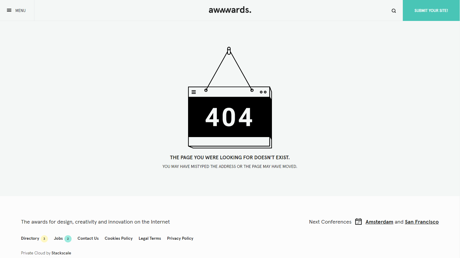

In [8]:
example = train_dataset[2]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [9]:
from transformers import AutoTokenizer 
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning", kwargs="padding")
processor= AutoTokenizer.from_pretrained("microsoft/git-large", kwargs="padding")

In [10]:
processor.pad_token

'[PAD]'

In [11]:
train_ds = ImageCaptioningDataset(train_dataset, image_processor, processor)
test_ds = ImageCaptioningDataset(test_dataset, image_processor, processor)

In [12]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=50)
test_dataloader = DataLoader(test_ds, shuffle=True, batch_size=10)

In [13]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([50, 3, 224, 224])
input_ids torch.Size([50, 512])
attention_mask torch.Size([50, 512])
labels torch.Size([50, 512])


### Training

In [14]:
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [17]:
training_args = TrainingArguments(
    output_dir=DATA_PATHS["checkpoints_dir"],
    learning_rate=5e-5,
    num_train_epochs=1,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_steps=1,
    logging_steps=1,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [16]:
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large")

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Wer Score
1,11.874100,10.319144,28.169451
2,10.343300,9.944508,27.305489
3,9.997800,9.680499,28.990453
4,9.742700,9.454240,34.601432
5,9.512100,9.291996,34.391408
6,9.355400,9.204471,33.875895


TrainOutput(global_step=6, training_loss=10.13757292429606, metrics={'train_runtime': 1098.6982, 'train_samples_per_second': 0.087, 'train_steps_per_second': 0.005, 'total_flos': 109030597263360.0, 'train_loss': 10.13757292429606, 'epoch': 1.0})

#### Plot loss curves 

In [19]:
def plot_loss_curve(ax, train_losses, plot_title):
    ax.plot(train_losses, label=plot_title, color='blue')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.set_title(plot_title)
    ax.legend()
    ax.grid(True)

In [20]:
track_losses = ["loss", "eval_loss", "eval_wer_score"]
losses = {key: [record[key] for record in trainer.state.log_history if key in record] for key in track_losses}

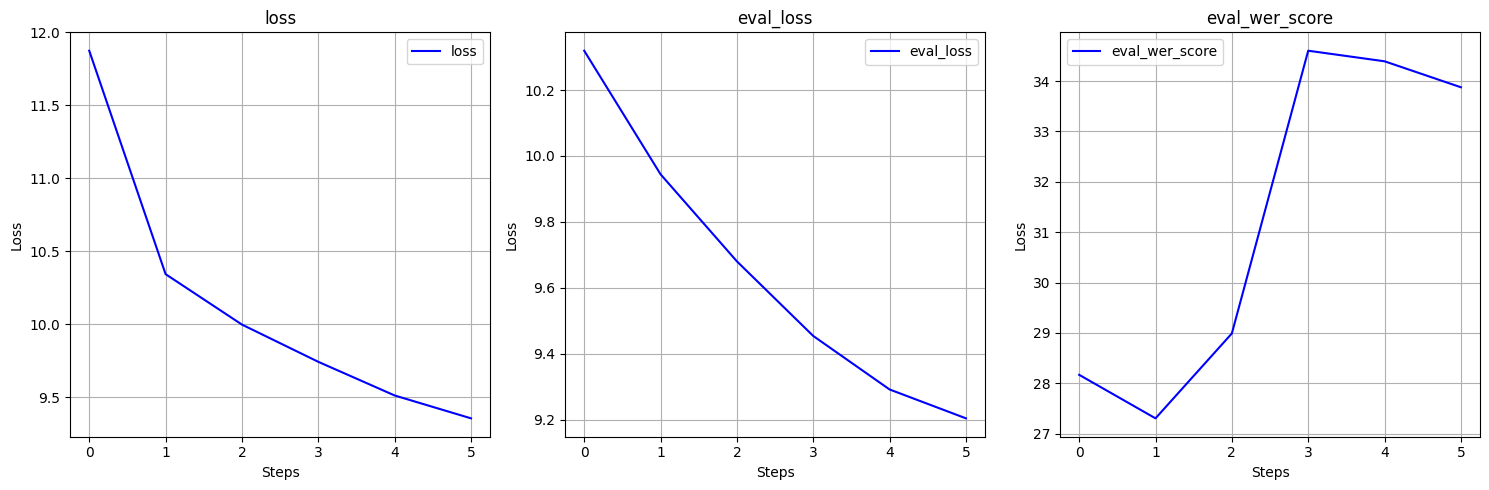

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index, loss in enumerate(track_losses): 
    plot_loss_curve(axs[index], losses[loss], loss)

plt.tight_layout()
plt.show()

#### Save model 

In [ ]:
trainer.save_model(DATA_PATHS["save_model_dir"])